In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

In [2]:
from numba import jit

In [3]:
from matplotlib import cm

In [4]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an equation of the form 
    d/dt(y) = f(y,t)
    this class takes a slope function, a method that calculates the step in value of y
    
    '''
    def __init__(self, slope_func, method ='rk4' ):
        '''
        initiates the ODE solver with a slope function and a step method 
        '''
        self.slope = slope_func
        self.set_method(method)
    
    def set_method(self, method):
        '''
        sets the method to calculate increment from y_i to y_(i+1)
        '''
        match method:
            case 'euler':
                self.increment = self.euler
            case 'rk2':
                self.increment = self.rk2
            case 'rk4':
                self.increment = self.rk4
            case other:
                print(f'{method} not implemented, choosing rk4 instead.')
                self.increment = self.rk4
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self,y,t,dt,*slope_pparams,**slope_nparams):
        '''
        This function takes y(t) and returns the values of 
        y(t+dt) using a specified method and slope function
        '''
        y_now=y
        step = self.increment(y_now, t, dt, *slope_pparams,**slope_nparams)
        y_next = y_now + step
        
        return(y_next)
    
    
    

In [5]:
class CSTRModel():
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it
    given model properties 
    '''
    
    def __init__(self, tau=2, N=1, timedata={}, c_init='empty',inj_prot=None):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to inject one whole volume of the tank(s)
            N : number of subtanks the whole volume is divided into.
            timedata:
                the time data for simulation. this can be provided in two ways
                 1. a dictionary containing {'t_start, dt , t_end'}
                    t_start  : simulation start time 
                    dt: time diff between each simulation step
                    t_end  : simulation end time 
                 2. a list of simulation time stamps
            c_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell
            inj_protocol: injection protocol to use 
                   : takes values {'rect_1s', 'rect_2s', 'rect_3s', 
                                   'ramp_1s', 'ramp_2s', 'biphasic'}

        '''
        # set and initialize temporal parameters 
        self.make_time(timedata)
        
        # set and initialize spatial parameters 
        self.make_spatial( N, c_init)
        
        # injection protocol. cinj stores the concentration of injection 
        # create a list of concs being injected at each time step
        self.make_injection_protocol(inj_prot)
        
        # store model parameters
        self.tau = tau   # physical model parameter
        
    def make_injection_protocol(self, protocol):
        '''
        makes injection protocol
        '''
        self.inj_prot = protocol
        match protocol:
            case 'rect_1s':
                self.inj_t = [0,1.,1.,2.,3.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_2s':
                self.inj_t = [0,2.,2.,3.,4.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_3s':
                self.inj_t = [0,3.,3.,4.,5.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'ramp_1s':
                self.inj_t = [0,1.,1.,2.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'ramp_2s':
                self.inj_t = [0,2.,2.,3.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'biphasic':
                self.inj_t = [  0,1.0,1.,2.,2.,3.,3.,4.]
                self.inj_c = [0.7,0.7,0.,0 ,1 ,1 ,0 ,0 ]
            case None:
                self.inj_t = [0,1.]
                self.inj_c = [0, 0]
        
    def cinj(self, t):
        '''
        returns injection concentration at a given time
        '''
        return(np.interp(t,self.inj_t, self.inj_c))
        
    def make_spatial(self, N, c_init='empty'):
        # set initial condition of concs before sim starts
        self.N = int(N)  #number of mixing tanks in series
        match c_init: 
            case str():
                match c_init:
                    case 'first':
                        c_init = np.zeros(self.N)
                        c_init[0] = 1     # set the tracer concentration in first mixing tank to 1
                                          # conc in all other tanks is 0
                    case 'empty':
                        c_init = np.zeros(int(self.N)) # there are no trancer conc anywhere else
            case list() | np.ndarray():
                c_init = c_init   # set the initial concentrations of tanks if its provided. 
            case other:
                print('Node signature not recognized')
        self.c_init=c_init

    def make_time(self, timedata):
        '''
        set model time paramters
        '''
        match timedata:
            case list() | np.ndarray():
                #print(f'assigning time, its a list of l {len(timedata)}')
                self.ts = np.array(timedata)
                self.t_st, self.t_end = timedata[0], timedata[-1]
            case dict():
                self.t_st = timedata['t_start']
                self.t_end = timedata['t_end']
                dt = timedata['dt']
                self.ts = np.arange(self.t_st, self.t_end,dt)
                self.ts=np.append(self.ts, self.t_end)
            case other:
                print('Time signature not recognized')
        self.dts = self.ts[1:]- self.ts[:-1]
        
    def cstr(self, conc, ti,N=2,tau=2):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSTR time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''
        #print(ti, ts)
        #tau=self.tau
        #N=self.N
        #print(N)
        Cinj_t = self.cinj(ti) # injection concentration at ti
        c = np.append(Cinj_t, conc)  # we append the injection
        slope = N/tau*(c[:-1]-c[1:])
        #print('conc including injection:',c)
        return(slope)
    
    def time_sim(self, N, tau, c_init='empty', ODEmethod='rk4'): 
        '''
        Performs the time domain simulation on the model. 
        It is possible to change the model parameters N and tau at runtime
        returns the concentration c_out (concentration in the last tank.)
        
        '''
        # solution.append(list(self.y_0))
                
        # remake the grids
        self.make_spatial(N,c_init)
        self.tau=tau
        
        c_now = self.c_init    # set conc values to initial value
        #print('assigning c_init', c_now)
        c_out=c_now[-1:]      #save 
        
        slope_func=self.cstr
        s = ODEsolvers(slope_func=slope_func, method=ODEmethod)
        solver = s.solver
        nparams = {'N': self.N, 'tau':self.tau}
        for t,dt in zip(self.ts[:-1], self.dts):
            #print('conc matrix i m passing', c_now)
            c_next = solver(c_now, t, dt, **nparams)
            #print('slope matrix i m passing', step)
            #c_next = c_now+step
            c_out=np.append(c_out,c_next[-1])
            #solution.append(y_next)
            c_now= c_next
            #print(c_now)
        return c_out       
    
    def analytical(self, c0=1):
        '''
        Returns the analytical solution to a CSTR model
        the analytical solution is avaiable for max 3 cells
        the analytical solution is possible for 4 cells or higher
        '''
        ts = self.ts
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-ts/tau)
            case 2:
                return 2*c0*ts/tau*np.exp(-2*ts/tau)
            case 3:
                return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
            case other:
                print('Not implemented')
                return(None)
            
    def props(self):
        '''
        this method is used for debugging
        returns the assigned attributes of the
        '''
        return [i for i in cls.__dict__.keys() if i[:1] != '_']
    
    def __repr__(self):
        out = f'CSTRModel(tau={self.tau}, N={self.N}, dt={self.dt}, Tmax={self.Tmax},c_init={self.c_init},inj_prot={self.inj_prot}))'
        return(out)
    
    def __str__(self):
        out = f'A CSTR model with {self.N} tanks and  residence time of {self.tau}s. \n'+\
        f'Simulation time:[0s to {self.Tmax}s with timesteps {self.dt}].\n'+\
        f'Initial concentration is {self.c_init} and injection protocol is {self.inj_prot}'
        return(out)    
    

# Exercise 1: 

## Part 1
Implemented OED solver and made a CSRT model 

## Part 2
Test you implementation against the analytical solutions in equation (3)
for n = 1, 2 and 3.

In [43]:
def comparision_plot(N,dt,ts,analitical, soln1, soln2, soln3):
    '''
    creates plots for of the time sim results 
    for various solver methods vs analytical soln
    '''
    # plt.clf()
    fig, axs=plt.subplots(nrows=2, figsize=(8,6))

    ax=axs[0]
    ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, soln1,'-*',markersize=7, label='euler')
    ax.plot(ts, soln2,'-*',markersize=5, label='rk2')
    ax.plot(ts, soln3,'-*',markersize=2, label='rk4')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Tank/exit concentration,\n Number of tank:{N}, deltaT: {dt}')
    ax.legend()
    
    ax=axs[1]
    #ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts[1:], np.abs(soln1[1:]-analitical[1:]),'-*',markersize=7, label='euler')
    ax.plot(ts[1:], np.abs(soln2[1:]-analitical[1:]),'-*',markersize=5, label='rk2')
    ax.plot(ts[1:], np.abs(soln3[1:]-analitical[1:]),'-*',markersize=2, label='rk4')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n Number of tank: {N}, deltaT: {dt}')
    ax.legend()
    
    major_ticks = np.arange(ts[0], ts[-1] + 1, 1)
    for ax in axs:
        ax.set_xlim(ts[0]-0.5, ts[-1]+0.5)
        ax.tick_params(axis='x', which='both', direction='in', length=8)
        ax.set_xticks(major_ticks)
        ax.tick_params(axis='both', which='both', direction='in', length=3)
    
    plt.tight_layout()


In [44]:
def method_comparision(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#
    
    methods = ['euler', 'rk2', 'rk4']
    soln = [0]*len(methods)
    for i, method in enumerate(methods):
        soln[i]=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)
    
    #print(soln1,soln2,soln3)
    ts=model.ts
    analitical= model.analytical()
    comparision_plot(N,dt,ts,analitical, *soln)

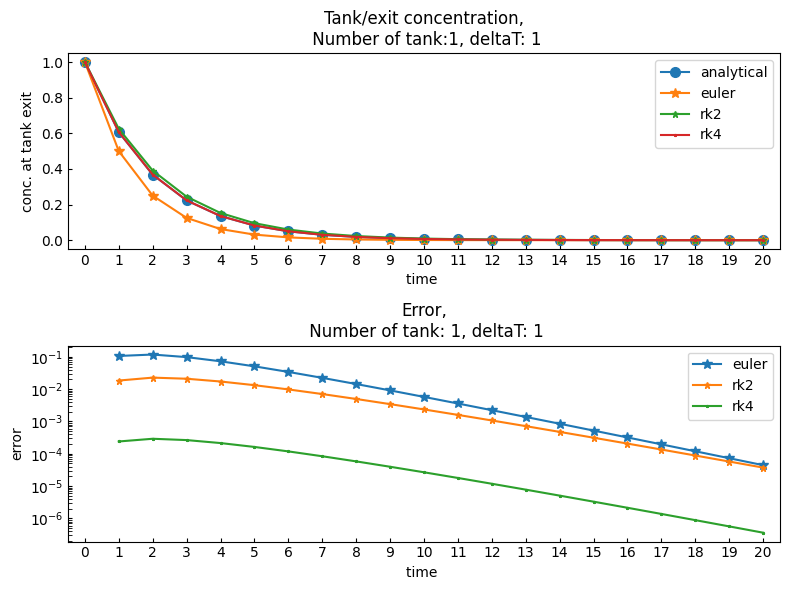

In [45]:
method_comparision(tau=2, N=1, dt=1, Tmax=20, c_init='first')

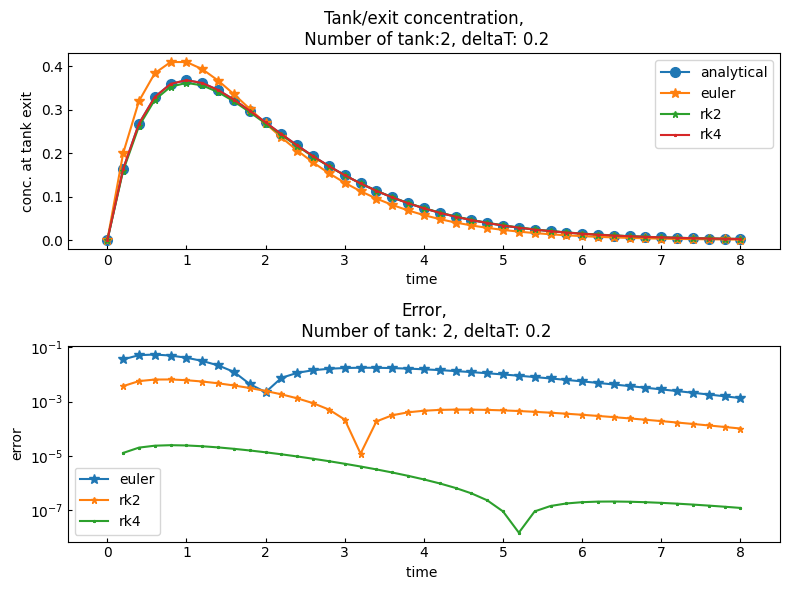

In [46]:
method_comparision(tau=2, N=2, dt=0.2, Tmax=8, c_init='first')

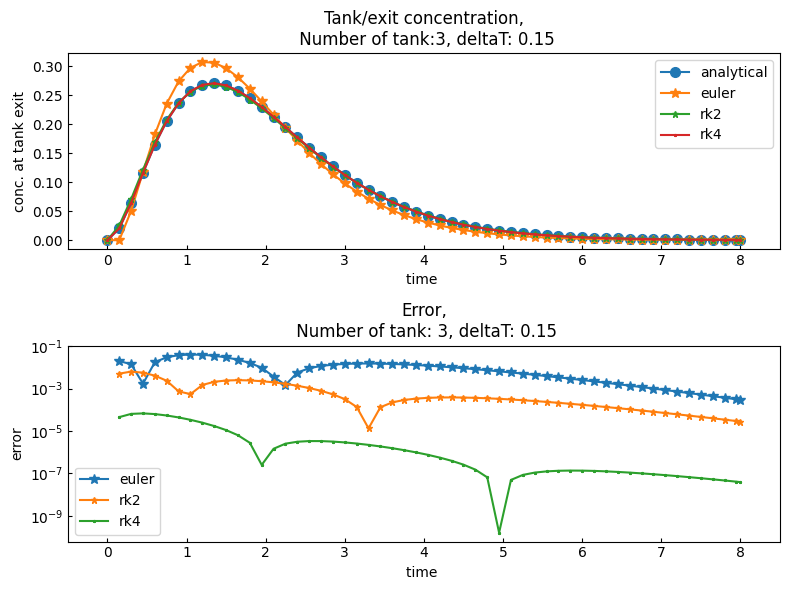

In [48]:
method_comparision(tau=2, N=3, dt=0.15, Tmax=8, c_init='first')

## Part 3. 
Pick n =1, 2, or 3
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range 0.1, . . . 0.001. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

In [ ]:
# parameters. do this for finer dt scaling
n = 5 # used to calculated 10**-n
tau = 2
Tmax = 1 # time at which the error is calculated
c_init = 'first'  # initial concs in the tanks

# time deltas
dts = np.geomspace(.1, 10**-n, n)-1e-15
print(dts)

# make the figure
fig, axs = plt.subplots(nrows = 3, figsize=(5,10))
for N, ax in zip([1,2,3], axs):    
    for method in ['euler', 'rk2', 'rk4']:
        error = []
        for dt in dts:
            # make model
            timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
            model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
            
            # find numerical solution to and keep only the result at t= Tmax
            soln =model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)[-1]
            
            # find solution to and keep only the result at t= Tmax
            analytical = model.analytical()[-1]
            
            # find error
            error.append(np.abs(soln-analytical))
        err_slope=np.log((error[2]-error[0])/(dts[2]-dts[0]))
        print(N, method,err_slope,end ='    ')
        ax.plot(dts, error,'-*' ,label=method)

        # print(method,error)
    print()
    ax.set(xlabel='dt(in secs)', ylabel='error',
           title=f'Model error at $t=1s$ for {N} tanks',
           ylim=(10**-18,0.1),xscale='log', yscale='log')
    ax.legend()
plt.tight_layout()

# Exercise 2: Fit CSTR model to CFD model: Healthy aorta
## part 1: Find the flow rate q

In [ ]:
concdata = pd.read_csv('data/Healthy_rect_1s.csv')
dt = concdata.Time[1]-concdata.Time[0] # in seconds
dt =dt/60  # convert to mins
Minj = 83.333 #in grams
q = Minj/concdata.Concentration.sum()/dt   
(f'Flow rate from healthy heart data: {q:0.2f} ml/min or {q/1000:0.2f}L/min')

## Part 2: Replicate injection protocols



In [ ]:
protocols = ['rect_1s', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
t = concdata.Time.to_numpy()
Tmax = t.max()
dt = 0.02
fig, axs = plt.subplots(nrows = 2, ncols = 3)
axs = axs.flatten()
for ax, protocol in zip(axs, protocols):
    #timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(timedata=t, inj_prot=protocol)
    c = model.cinj(t)  # injection concentrations
    ax.plot(t,c)
    ax.grid()
    ax.set_title(protocol)
fig.supylabel('Tracer conc(g/ml)')
fig.supxlabel('time(s)')
plt.tight_layout()

## Part 3 Fit data


In [ ]:
def load_CFD_data(healthy=True, protocol = 'rect_1s'):
    if healthy: h = 'Healthy'
    else: h = 'Aneurysm'
        
    datafile = f'data/{h}_{protocol}.csv'
    print(datafile)
    concdata = pd.read_csv(datafile)
    t = concdata.Time.to_numpy()
    conc_CFD = concdata.Concentration.to_numpy()
    return(t,conc_CFD)

In [ ]:
def plot_SSR_Surface(t,conc_CFD,taus=np.arange(2.,3.,0.1),Ns= np.arange(45,53,1),\
                      levels = np.arange(0,1,0.1)):
    x = taus # tau
    y =  Ns # N
    #t,conc_CFD=load_CFD_data(healthy=healthy, protocol=protocol)
    print(f'N:{len(y)}  taus:{len(x)}')
    X,Y = np.meshgrid(x, y) # grid of point
    Z=[]
    for x,y in (zip(X,Y)):
        z=[]
        for tau,N in (zip(x,y)):
            #print(_)
            z.append(SSR(tau= tau,N=N,xdata=t, ydata = conc_CFD))
        Z.append(z)
    Z=np.array(Z)
    idx=np.where(Z==Z.min())
    print(f'min error: {Z.min()}')
    print(f'parameters: {X[idx]}{Y[idx]}')

    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(projection = '3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
    plt.figure()
    cset = plt.contour(X,Y,Z,levels = levels, linewidths=2,cmap=cm.Set2)
    #cset=contour(X,Y,Z)
    plt.clabel(cset,inline=True,fmt='%.5f',fontsize=10)
    plt.scatter(X[idx],Y[idx], label='minima')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    #colorbar(im) # adding the colobar on the right
    plt.title('Contour')
    a = plt.legend()


In [ ]:
class Minimizer():
    '''
    provides various minimization tools
    '''
    def __init__(self, prec=1e-8,MAXIT=10):
        self.prec=prec
        self.MAXIT=MAXIT
        
    def gradient(self, f,x, dx=10e-4,**kwarg):
        '''
        takes a function f and returns its gradient(df/dx) at x
        using central difference, 
        '''
        return (f(x+dx,**kwarg)-f(x-dx,**kwarg))/2/dx
    
    def curvature(self, f,x,dx=10e-4,**kwarg):
        '''
        takes a function f and returns its curvature (d**2f/dx**2) at x
        using central difference, 
        '''
        curvature = (f(x+dx,**kwarg)-2*f(x,**kwarg)+f(x-dx, **kwarg))/2/dx
        
    def gradient_descent(self, f,x,df, g=.001, **kwarg):
        '''Minimize f(x) by gradient descent.
        f   : min(f(x))
        x   : starting point 
        df  : derivative of f(x)
        g   : learning rate
        prec: desired precision

        Returns x when it is closer than eps to the root, 
        unless MAXIT are not exceeded
        '''
        x_old = x
        df_old=df(f,x_old,**kwarg)
        for n in range(self.MAXIT):
            #plot_regression_line(x_old)  
            x_new = x_old - g*df_old
            if(np.max(np.abs(x_new-x_old))<self.prec):
                print('Found solution:', x_new, 
                      ', after:', n, 'iterations.' )
                return x_new
            x_old=x_new
            df_old=df(f,x_old,**kwarg)

        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', x_guess:=f(x_new))
        return x_new,np.array(x_guess)

    def Jacobian(self,f,x,dx=1e-5,**kwarg):
        N=len(x)
        f0=f(x,**kwarg)
        #print('in jacobian f0=f(x,**kwarg)')
        J=np.zeros(shape=(N,N))
        #print(J,f0)
        for j in range(N):
            x[j] = x[j] +  dx
            fx=f(x,**kwarg)
            for i in range(N):   
                J[i][j] = (fx[i]-f0[i])/dx
                #print(f'assigning J{i},{j}')
            x[j] = x[j] -  dx
        return J

    def newton_raphson(self, f,x,J=None, jacobian=False,**kwarg):
        '''Approximate solution of f(x)=0 by Newtons method.
        The derivative of the function is calculated numerically
        f   : f(x)=0.this is the derivative
        J   : Jacobian
        x   : starting point  
        eps : desired precision

        Returns x when it is closer than eps to the root, 
        unless MAX_ITERATIONS are not exceeded
        '''
        MAX_ITERATIONS=self.MAXIT
        #x=args
        self.n_iter = 0 
        x_old = np.copy(x)
        for n in range(MAX_ITERATIONS):
            #plot_regression_line(x_old) 
            self.n_iter = n
            if not jacobian:
                #print('call Jac with',x_old)
                J_=self.Jacobian(f,x_old,**kwarg)
            else:
                J_=J(x_old)
            z=np.linalg.solve(J_,-f(x_old,**kwarg))
            x_new=x_old+z
            if(np.sum(abs(x_new-x_old))<self.prec):
                #print('Found solution:', x_new, 
                #      ', after:', n, 'iterations.' )
                return x_new
            x_old=np.copy(x_new)
        print('Max number of iterations: ', self.MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', f(x_new))
        return x_new

In [ ]:
def SSR(tau, xdata=[], ydata=[], N=1, inj_prot=protocol):
    '''
    Returns the sum of squared residuals
    params:
        N, tau and inj_prot(injection protocol) : model parameters
        xdata is the time data
        ydata is the curve we need to fit to
    returns the SSR
    '''
    timedata = xdata
    conc_CFD = ydata
    model = CSTRModel(tau=tau, N=N, timedata=timedata, inj_prot=inj_prot)
    conc_out = model.time_sim(N, tau)
    #print (f'conc_CFD: {len(conc_CFD)}, conc_out: {len(conc_out)}')
    SSR = np.sum((conc_CFD-conc_out)**2)
    return SSR

def dSSR(tau,**kwarg):
    '''
    returns the slope of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        slope of SSR
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(SSR, tau,**kwarg)]))

def ddSSR(tau,**kwarg):
    '''
    returns the curvature of the SSR function at the tau using 
    central diff from our minimizer
    params:
        tau : model parameter (residence time)
    returns 
        curvature of SSR at tau
    '''
    a = Minimizer()
    gradient = a.gradient
    return (np.array([gradient(dSSR, tau,**kwarg)]))


In [ ]:
def fit_CFD_data(healthy=True, protocol='rect_1s', Ns=range(47, 52), solver='NR', ax=None):
    '''
    does the following things:
       1. reads CFD simulated data
       2. cycles through various number of tanks and finds optimal 
          tau at each N. 
       3. plots the 
    '''

    t, conc_CFD = load_CFD_data(healthy, protocol)  # reads CFD data
    leastSSR = 200_000  # set value of SSR to some ridiculous value
    m = Minimizer()

    for N in Ns:
        params = {'xdata': t, 'ydata': conc_CFD, 'N': N, 'inj_prot': protocol}
        tau = 2.  # first guess
        if solver == 'graddesc':
            tau_ = m.gradient_descent(
                f=SSR, x=tau, df=dSSR, MAXIT=10000, **params)
        else:
            # newton raphson implimentation takes a list and returns a list
            # so the input requires to be sent as a list.
            tau_ = m.newton_raphson(
                x=[tau], f=dSSR, jacobian=False, **params)[0]
        ssr = SSR(tau=tau_, **params)
        if ssr < leastSSR:
            optimal_N = N
            optimal_tau = tau_
            print(f'new optimal tau found {optimal_tau:0.4f}s, >N= {optimal_N}, SSR: {ssr}')
            leastSSR = ssr
        '''
        #uncomment this part if you want the loop to stop once SSR starts incereasing with N
        else:
            print(
                f'Minima found at N={optimal_N} tanks and τ ={optimal_tau:.4f},',
                f' using {solver} in {m.n_iter} iterations(avg)')
            print('-'*80)
            break
        '''    
    print(f'Minima found at N={optimal_N} tanks and τ ={optimal_tau:.4f},',
                f' using {solver} in {m.n_iter} iterations(avg)')
    print('-'*80)
    
    tau = optimal_tau
    N = optimal_N
    model = CSTRModel(tau=tau, N=N, timedata=t, inj_prot=protocol)
    #conc_model_manual = model.time_sim(N, tau)
    conc_model_fitted = model.time_sim(N, tau)
    injection = model.cinj(t)

    #fig, ax = plt.subplots()
    #ax.plot(t, conc_model_manual,'*', markersize=2 ,label = 'numerical manual')
    ax.plot(model.ts, conc_model_fitted, 'o', color ='b',
            markersize=1, label='numerical'+solver,)
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', alpha=0.5, lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    

    ax.set_title(f'{optimal_N} tanks, τ = {optimal_tau:.4f}s\n'+ f'{protocol}')
    # ax.legend()

    return(optimal_N, optimal_tau)

## Part 3: 
**For the 1s rectangular pulse injection protocol, tune  = Vtot/q and
the number of compartments to match the data for the healthy patient
(Healthy_rect_1s.csv) .**

In [ ]:
t, conc_CFD = load_CFD_data(healthy=True, protocol='rect_1s')
plot_SSR_Surface(t,conc_CFD,Ns=np.arange(10,60,1),taus=np.arange(2,3.5,0.1),levels=np.arange(11,15,0.2))

In [ ]:
protocol = 'rect_1s'
fig, ax = plt.subplots()
optimal_N_re1s, optimal_tau_re1s = fit_CFD_data(
    healthy=True, protocol=protocol, Ns=range(20, 60), solver='NR', ax=ax)

ax.set_title(f'Fitting CSTR model to  healthy heart data')
ax.set_xlabel(f'Simulation time(s)')
ax.set_ylabel(f'Concentration at exit $Cout$ (s)')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
plt.grid()
plt.tight_layout()

## Part 4
Model prediction.
It is important that you do not change n or VTot in this part. Here we
have used the rect_1s to tune the model and now we test how good it is
by predicting other injection protocols

Choose at least three other injection protocol than rect_1s from figure 5,
use the model you ended up with in part 3 to predict what will happen.

In [ ]:
N = optimal_N_re1s
tau = optimal_tau_re1s

protocols = [f'rect_{i}s' for i in [1, 2, 3]] +\
            [f'ramp_{i}s' for i in [1, 2]] +\
            [f'biphasic']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
axs = np.ndarray.flatten(axs)

for ax, protocol in zip(axs, protocols):
    t, conc_CFD = load_CFD_data(protocol=protocol)
    model = CSTRModel(timedata=t, inj_prot=protocol)
    y = model.time_sim(N=N, tau=tau)
    injection = model.cinj(t)
    
    ax.plot(model.ts, y, 'o', color ='b',
            markersize=1, label='numerical')
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    ax.set_title(protocol)
    ax.grid()
fig.suptitle(f'Using rect_1s tuned parameters on other injection protocols ')
fig.supxlabel(f'Simulation time(s)')
fig.supylabel(f'Concentration at exit $Cout$ (s)')
handles = ax.get_legend_handles_labels()
fig.legend(*handles,loc='lower right', ncol=5)
plt.tight_layout()

# Exercise 3: Fit CSTR model to CFD model: Aorta with aneurysm

## Part 1.
• Repeat exercise 2, part 3 for the case of the unhealthy patient with an
aneurysm. Note: you have to find new values for n and VTot.
The relevant data is found in the text file Aneurysm_rect_1s.csv.

In [ ]:
t, conc_CFD = load_CFD_data(healthy=False, protocol='rect_1s')
plot_SSR_Surface(t,conc_CFD,Ns=np.arange(10,50,1),taus=np.arange(2,3.5,0.1),levels=np.arange(11,15,0.2))

In [ ]:
protocol = 'rect_1s'
fig, ax = plt.subplots()
optimal_N_re1s, optimal_tau_re1s = fit_CFD_data(
    healthy=False, protocol=protocol, Ns=range(10, 60), solver='NR', ax=ax)

ax.set_title(f'Fitting CSTR model to heart with anurism data'+f'\nN:{optimal_N_re1s},τ:{optimal_tau_re1s:0.3f}')
ax.set_xlabel(f'Simulation time(s)')
ax.set_ylabel(f'Concentration at exit $Cout$ (s)')
#handles = ax.get_legend_handles_labels()
ax.legend()  # (*handles,loc='lower right', ncol=5)
plt.grid()
plt.tight_layout()

## Part 2.
• Similarly, repeat exercise 2, part 4 for the case with an aneurysm

In [ ]:
N = optimal_N_re1s
tau = optimal_tau_re1s

protocols = [f'rect_{i}s' for i in [1, 2, 3]] +\
            [f'ramp_{i}s' for i in [1, 2]] +\
            [f'biphasic']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))
axs = np.ndarray.flatten(axs)

for ax, protocol in zip(axs, protocols):
    t, conc_CFD = load_CFD_data(healthy= False, protocol=protocol)
    model = CSTRModel(timedata=t, inj_prot=protocol)
    y = model.time_sim(N=N, tau=tau)
    injection = model.cinj(t)
    
    ax.plot(model.ts, y, 'o', color ='b',
            markersize=1, label='numerical')
    ax.plot(model.ts, injection, '--', markersize=2,
            label='injection', lw=1)
    ax.plot(t, conc_CFD, label='CFD', color= 'r')
    ax.set_title(protocol)
    ax.grid()
fig.suptitle(f'Using rect_1s tuned parameters on other injection protocols ')
fig.supxlabel(f'Simulation time(s)')
fig.supylabel(f'Concentration at exit $Cout$ (s)')
handles = ax.get_legend_handles_labels()
fig.legend(*handles,loc='lower right', ncol=5)
plt.tight_layout()

# fin

# DO not change 

In [ ]:
protocols = [f'rect_{i}s' for i in [1, 2, 3]] +\
            [f'ramp_{i}s' for i in [1, 2]] +\
            [f'biphasic']

#fit_CFD_data(healthy = True, protocol='ramp_2s', Ns=range(25,52),solver = 'NR')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7.5))
axs=np.ndarray.flatten(axs)

for ax,protocol in zip(axs[:],protocols):
    fit_CFD_data(healthy=True, protocol=protocol,
                 Ns=range(20, 60), solver='NR', ax=ax)
    ax.grid(alpha=0.5)

fig.suptitle(f'Fitting CSTR model to  healthy heart data')
fig.supxlabel(f'Simulation time(s)')
fig.supylabel(f'Concentration at exit $Cout$ (s)')
handles = ax.get_legend_handles_labels()
fig.legend(*handles,loc='lower right', ncol=5)
plt.tight_layout()

# fin